# Preparation
Импортируем необходимые модули

In [12]:
import time
import numpy as np
import pandas as pd
import kernels as k
import metrics as m
import matplotlib.pyplot as plt

Вынесем метрики в `metrics.py`:

In [ ]:
# %load metrics.py
import numpy as np

# Metrics
def distance_euclidean(row1, row2):
    distance = 0.0
    for i in range(len(row2) - 1):
        distance += (row1[i] - row2[i]) ** 2
    return np.sqrt(distance)


def distance_manhattan(row1, row2):
    distance = 0.0
    for i in range(len(row2) - 1):
        distance += abs(row1[i] - row2[i])
    return distance


def distance_chebyshev(row1, row2):
    distance = 0.0
    for i in range(len(row2) - 1):
        distance = max(distance, abs(row1[i] - row2[i]))
    return distance

metrics = {
    "euclidean": distance_euclidean,
    "chebyshev": distance_chebyshev,
    "manhattan": distance_manhattan,
}


Вынесем ядра в `kernels.py`:

In [ ]:
# %load kernels.py
# Kernels
def kernel_uniform(u):
    return 0.5 if abs(u) <= 1 else 0.0


def kernel_triangular(u):
    return max(0, 1 - abs(u))


def kernel_epanechnikov(u):
    return max(0, 0.75 * (1 - u * u))


def kernel_quartic(u):
    return max(0, 15 / 16 * ((1 - u * u) ** 2))


kernels = {
    "uniform": kernel_uniform,
    "triangular": kernel_triangular,
    "epanechnikov": kernel_epanechnikov,
    "quartic": kernel_quartic,
}

Считаем датасет.

In [2]:
# Link on dataset: https://www.openml.org/d/40975
filename = "cars.csv"
'''
CAR                      car acceptability
. PRICE                  overall price 
. . buying               buying price                          -- {low, med, high, vhigh}
. . maint                price of the maintenance              -- {low, med, high, vhigh}
. TECH                   technical characteristics
. . COMFORT              comfort                    
. . . doors              number of doors                       -- {2, 3, 4, 5more}
. . . persons            capacity in terms of persons to carry -- {2, 4, more}
. . . lug_boot           the size of luggage boot              -- {small, med, big}
. . safety               estimated safety of the car           -- {low, med, high}

CLASS                                                          -- {unacc, acc, good, vgood}
'''
dataset = pd.read_csv(filename)
print(dataset)

     buying  maint  doors persons lug_boot safety  class
0     vhigh  vhigh      2       2    small    low  unacc
1     vhigh  vhigh      2       2    small    med  unacc
2     vhigh  vhigh      2       2    small   high  unacc
3     vhigh  vhigh      2       2      med    low  unacc
4     vhigh  vhigh      2       2      med    med  unacc
...     ...    ...    ...     ...      ...    ...    ...
1723    low    low  5more    more      med    med   good
1724    low    low  5more    more      med   high  vgood
1725    low    low  5more    more      big    low  unacc
1726    low    low  5more    more      big    med   good
1727    low    low  5more    more      big   high  vgood

[1728 rows x 7 columns]


# Vectorization
Векторизуем датасет.

In [3]:

buying = maint = {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}
doors = {'2': 0, '3': 1, '4': 2, '5more': 3}
persons = {'2': 0, '4': 1, 'more': 2}
lug_boot = {'small': 0, 'med': 1, 'big': 2}
safety = {'low': 0, 'med': 1, 'high': 2}
target_variable_one_hot = {'unacc': np.array([0, 0, 0, 1]), 'acc': np.array([0, 0, 1, 0]), 'good': np.array([0, 1, 0, 0]), 'vgood': np.array([1, 0, 0, 0])}
target_variable_int = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}

def col_to_list(mapper, name_to_str):
    return list(map(lambda x: mapper.get(x, 0), dataset[name_to_str].values.tolist()))  # default = 0

def variables_to_data_frame():
    return pd.DataFrame({
        'buying': col_to_list(buying, 'buying'),
        'maint': col_to_list(maint, 'maint'),
        'doors': col_to_list(doors, 'doors'),
        'persons': col_to_list(persons, 'persons'),
        'lug_boot': col_to_list(lug_boot, 'lug_boot'),
        'safety': col_to_list(safety, 'safety')
    })

dataset_int = variables_to_data_frame()
dataset_int['class'] = col_to_list(target_variable_int, 'class')
dataset_one_hot = dataset_int
dataset_one_hot['class'] = col_to_list(target_variable_one_hot, 'class')
print(dataset_one_hot)

      buying  maint  doors  persons  lug_boot  safety         class
0          3      3      0        0         0       0  [0, 0, 0, 1]
1          3      3      0        0         0       1  [0, 0, 0, 1]
2          3      3      0        0         0       2  [0, 0, 0, 1]
3          3      3      0        0         1       0  [0, 0, 0, 1]
4          3      3      0        0         1       1  [0, 0, 0, 1]
...      ...    ...    ...      ...       ...     ...           ...
1723       0      0      3        2         1       1  [0, 1, 0, 0]
1724       0      0      3        2         1       2  [1, 0, 0, 0]
1725       0      0      3        2         2       0  [0, 0, 0, 1]
1726       0      0      3        2         2       1  [0, 1, 0, 0]
1727       0      0      3        2         2       2  [1, 0, 0, 0]

[1728 rows x 7 columns]


# Normalization
Нормализуем датасет.

In [4]:
def dataset_minmax(ds):
    minmax = list()
    for i in range(len(ds[0])):
        if i == len(ds[0]) - 1:
            continue
        value_min = ds[:, i].min()
        value_max = ds[:, i].max()
        minmax.append((value_min, value_max))
    return minmax

def normalize(ds, minmax):
    for row in ds:
        for i in range(len(row)):
            if i == len(row) - 1:
                continue
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])  # (x - min) / (max - min)
    return ds

min_max = dataset_minmax(dataset_one_hot.values)
norm = normalize(dataset_one_hot.values, min_max)
print(norm)
ds_norm = normalize(dataset_one_hot.values, min_max).tolist()


[[1.0 1.0 0.0 ... 0.0 0.0 array([0, 0, 0, 1])]
 [1.0 1.0 0.0 ... 0.0 0.5 array([0, 0, 0, 1])]
 [1.0 1.0 0.0 ... 0.0 1.0 array([0, 0, 0, 1])]
 ...
 [0.0 0.0 1.0 ... 1.0 0.0 array([0, 0, 0, 1])]
 [0.0 0.0 1.0 ... 1.0 0.5 array([0, 1, 0, 0])]
 [0.0 0.0 1.0 ... 1.0 1.0 array([1, 0, 0, 0])]]


# Hyperparameter setting

Нахождение ближайших `number_neighbors` соседей по метрике `metric` к элементу `test_row`.

In [5]:
def find_neighbors(ds_without_test, test_row, metric, number_neighbors):
    neighbours = [(metric(test_row, train_row), train_row[-1]) for train_row in ds_without_test]
    neighbours.sort(key=lambda tup: tup[0])
    return neighbours[:number_neighbors + 1]

Решение на основе формулы [Надарая-Ватсона](http://www.machinelearning.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%9D%D0%B0%D0%B4%D0%B0%D1%80%D0%B0%D1%8F-%D0%92%D0%B0%D1%82%D1%81%D0%BE%D0%BD%D0%B0) c метрикой `metric`, ядром `kernel`, количеством ближайших соседей `number_neighbors`.

In [6]:
def calc_nadaraya(ds_without_test, test_row, metric, kernel, number_neighbors):
    neighbours = find_neighbors(ds_without_test, test_row, metric, number_neighbors)
    numerator = 0
    denominator = 0
    h = neighbours[-1][0]
    for neighbour in neighbours:
        numerator += neighbour[1] * kernel(neighbour[0] / h)
        denominator += kernel(neighbour[0] / h)
    return numerator / denominator if denominator != 0 else 0

Leave-One-Out перекрёстная проверка

In [7]:
def class_to_int(target_class):
    return np.argmax(target_class)

def leave_one_out(ds, test_index, metric, kernel, number_neighbors):
    test_row = ds[test_index]
    ds_without_test = ds[:test_index] + ds[test_index + 1:]
    nadaraya = calc_nadaraya(ds_without_test, test_row, metric, kernel, number_neighbors)
    return class_to_int(test_row[-1]), class_to_int(nadaraya)

Посчитаем [F-меру](http://bazhenov.me/blog/2012/07/21/classification-performance-evaluation.html) с использованием матрицы неточностей (confusion matrix).

In [8]:
def cals_f_measure(ds, metric, kernel, number_neighbors):
    number_classes = len(target_variable_one_hot)
    confusion_matrix = np.zeros((number_classes, number_classes))
    for test_index in range(len(ds)):
        res = leave_one_out(ds, test_index, metric, kernel, number_neighbors)
        confusion_matrix[res[0]][res[1]] += 1  
    
    size = len(confusion_matrix)
    precision = sum([confusion_matrix[i][i] / max(sum(confusion_matrix[i]), 0.01) for i in range(size)]) / size
    recall = sum([confusion_matrix[i][i] / max(sum(confusion_matrix[:, i]), 0.01) for i in range(size)]) / size
    return 2 * precision * recall / (precision + recall)

# Analysis of results and charting
Перебираем гиперпараметры и находим лучшую комбинацию (предподсчет).

In [9]:
def find_best(ds):
    all_result = {}
    for (kernel_name, kernel) in k.kernels.items():
        for (metric_name, metric) in m.metrics.items():
            for number_neighbors in range(1, int(np.sqrt(len(ds)))):
                name = kernel_name + "-" + metric_name + "-" + str(number_neighbors)
                res = cals_f_measure(ds, metric, kernel, number_neighbors)
                all_result[name] = res
                f.write(name + "," + str(res) + "\n")

# finds the best combination of hyperparameters (pre-calculation)
f = open(r"ans.txt", 'a')
start_time = time.time()
# find_best(ds_norm)
f.close()

Строим график совпадения.

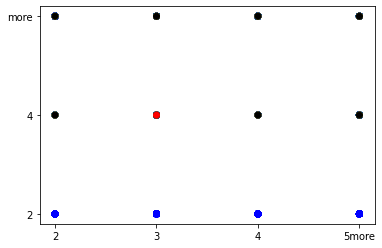

In [10]:
def plot_predict(ds, index, x, y):
    class_to_color = list(map(lambda clazz: {'unacc': 'b', 'acc': 'c', 'good': 'y', 'vgood': 'k'}[clazz], ds[:, -1]))
    class_to_color.append("r")

    col_x = list(ds[:, x])
    col_x.append(ds[index][x])
    col_y = list(ds[:, y])
    col_y.append(ds[index][y])

    plt.scatter(col_x, col_y, c=class_to_color)
    plt.show()
    
plot_predict(dataset.values, 38, 2, 3)

Для лучшей найденной комбинации гиперпараметров строим график зависимости F-меры от числа ближайших соседей.

Best hyperparameters (with result 0.9766946409812967): uniform-manhattan-4
F-measures:

1.	0.7666573060111855
2.	0.8174136069997151
3.	0.9160471525327393
4.	0.9766946409812967
5.	0.9603152360582091
6.	0.9416091901026553
7.	0.9388944938304735
8.	0.9351014242505802
9.	0.912556363218965
10.	0.8954151220316312
11.	0.8849886893562765
12.	0.8492237707691243
13.	0.8439055741591515
14.	0.8403184247557776
15.	0.8522836069507957


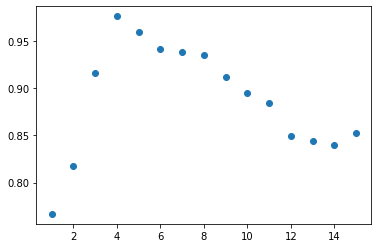

Total working time: 44.10533857345581 seconds.


In [11]:
f = open('ans.txt')
params = {line.split()[1]: line.split()[0] for line in f}
best_f_measure = max(params)
best_params = params[best_f_measure]
print('Best hyperparameters (with result ' + str(best_f_measure) + '): ' + best_params)

best_params_to_list = best_params.split('-')
best_kernel = best_params_to_list[0]
best_metric = best_params_to_list[1]
best_number_neighbors = int(best_params_to_list[2])

def graph(ds, metric, kernel, best_num):
    max_number_neighbors = range(1, best_num ** 2)
    results = []
    print('F-measures:\n')
    for number_neighbors in max_number_neighbors:
        res = cals_f_measure(ds, metric, kernel, number_neighbors)
        print(str(number_neighbors) + ".\t" + str(res))
        results.append(res)
    plt.scatter(max_number_neighbors, results)
    plt.show()

graph(ds_norm, m.metrics[best_metric], k.kernels[best_kernel], best_number_neighbors)

print("Total working time: %s seconds." % (time.time() - start_time))